# Building a simple nowcasting model

In [1]:
%matplotlib inline

Nowcasting is a special case of forecasting. It simply consists in predicting the next value in a time series.

We'll be using the international airline passenger data available from [here](https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line). This particular dataset is included with `river` in the `datasets` module.

In [2]:
from river import datasets

for x, y in datasets.AirlinePassengers():
    print(x, y)
    break

{'month': datetime.datetime(1949, 1, 1, 0, 0)}
112

The data is as simple as can be: it consists of a sequence of months and values representing the total number of international airline passengers per month. Our goal is going to be to predict the number of passengers for the next month at each step. Notice that because the dataset is small  -- which is usually the case for time series -- we could just fit a model from scratch each month. However for the sake of example we're going to train a single model online. Although the overall performance might be potentially weaker, training a time series model online has the benefit of being scalable if, say, you have have [thousands of time series to manage](http://www.unofficialgoogledatascience.com/2017/04/our-quest-for-robust-time-series.html).

We'll start with a very simple model where the only feature will be the [ordinal date](https://www.wikiwand.com/en/Ordinal_date) of each month. This should be able to capture some of the underlying trend. 

In [3]:
from river import compose
from river import linear_model
from river import preprocessing


def get_ordinal_date(x):
    return {'ordinal_date': x['month'].toordinal()}


model = compose.Pipeline(
    ('ordinal_date', compose.FuncTransformer(get_ordinal_date)),
    ('scale', preprocessing.StandardScaler()),
    ('lin_reg', linear_model.LinearRegression())
)

We'll write down a function to evaluate the model. This will go through each observation in the dataset and update the model as it goes on. The prior predictions will be stored along with the true values and will be plotted together. 

In [4]:
from river import metrics
from river import utils
import matplotlib.pyplot as plt


def evaluate_model(model): 
    
    metric = utils.Rolling(metrics.MAE(), 12)
    
    dates = []
    y_trues = []
    y_preds = []

    for x, y in datasets.AirlinePassengers():
        
        # Obtain the prior prediction and update the model in one go
        y_pred = model.predict_one(x)
        model.learn_one(x, y)
        
        # Update the error metric
        metric.update(y, y_pred)
        
        # Store the true value and the prediction
        dates.append(x['month'])
        y_trues.append(y)
        y_preds.append(y_pred)
        
    # Plot the results
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.grid(alpha=0.75)
    ax.plot(dates, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
    ax.plot(dates, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
    ax.legend()
    ax.set_title(metric)

Let's evaluate our first model.

<Figure size 720x432 with 1 Axes>

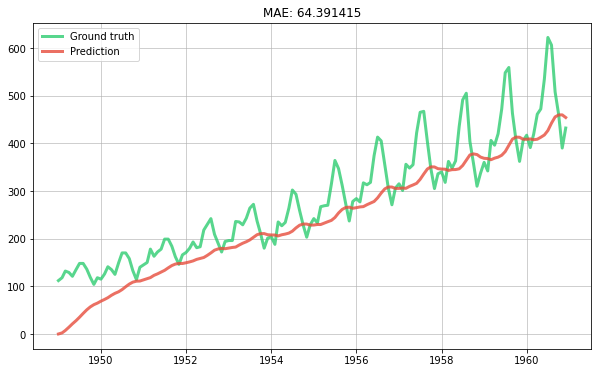

In [5]:
evaluate_model(model)

The model has captured a trend but not the right one. Indeed it thinks the trend is linear whereas we can visually see that the growth of the data increases with time. In other words the second derivative of the series is positive. This is a well know problem in time series forecasting and there are thus many ways to handle it; for example by using a [Box-Cox transform](https://www.wikiwand.com/en/Power_transform). However we are going to do something a bit different, and instead linearly detrend the series using a `TargetStandardScaler`.

<Figure size 720x432 with 1 Axes>

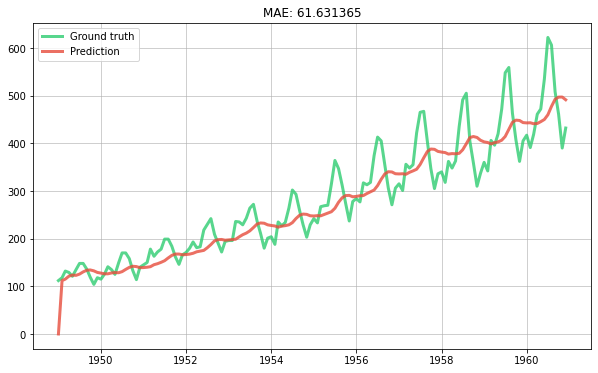

In [6]:
from river import stats


model = compose.Pipeline(
    ('ordinal_date', compose.FuncTransformer(get_ordinal_date)),
    ('scale', preprocessing.StandardScaler()),
    ('lin_reg', linear_model.LinearRegression(intercept_lr=0)),
)

model = preprocessing.TargetStandardScaler(regressor=model)

evaluate_model(model)

Now let's try and capture the monthly trend by one-hot encoding the month name.

<Figure size 720x432 with 1 Axes>

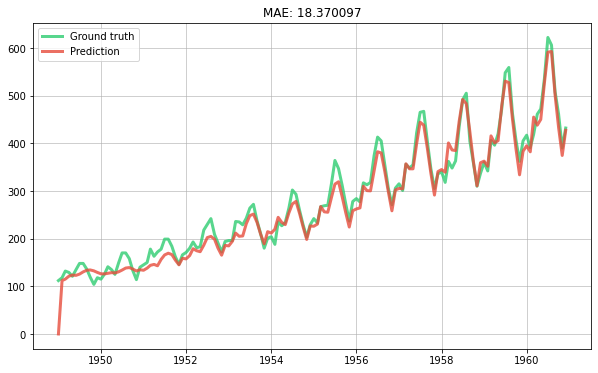

In [7]:
import calendar


def get_month(x):
    return {
        calendar.month_name[month]: month == x['month'].month
        for month in range(1, 13)
    }
    

model = compose.Pipeline(
    ('features', compose.TransformerUnion(
        ('ordinal_date', compose.FuncTransformer(get_ordinal_date)),
        ('month', compose.FuncTransformer(get_month)),
    )),
    ('scale', preprocessing.StandardScaler()),
    ('lin_reg', linear_model.LinearRegression(intercept_lr=0))
)

model = preprocessing.TargetStandardScaler(regressor=model)

evaluate_model(model)

This seems pretty decent. We can take a look at the weights of the linear regression to get an idea of the importance of each feature.

In [8]:
model.regressor['lin_reg'].weights

{
    'January': -0.13808091575141299,
    'February': -0.18716063793638954,
    'March': -0.026469206216021102,
    'April': -0.03500685108350436,
    'May': -0.013638742192777328,
    'June': 0.16194267303548826,
    'July': 0.31995865445067634,
    'August': 0.2810396556938982,
    'September': 0.03834350518076595,
    'October': -0.11655850082390988,
    'November': -0.2663497734491209,
    'December': -0.15396048501165746,
    'ordinal_date': 1.0234863735122575
}

As could be expected the months of July and August have the highest weights because these are the months where people typically go on holiday abroad. The month of December has a low weight because this is a month of festivities in most of the Western world where people usually stay at home.

Our model seems to understand which months are important, but it fails to see that the importance of each month grows multiplicatively as the years go on. In other words our model is too shy. We can fix this by increasing the learning rate of the `LinearRegression`'s optimizer.

<Figure size 720x432 with 1 Axes>

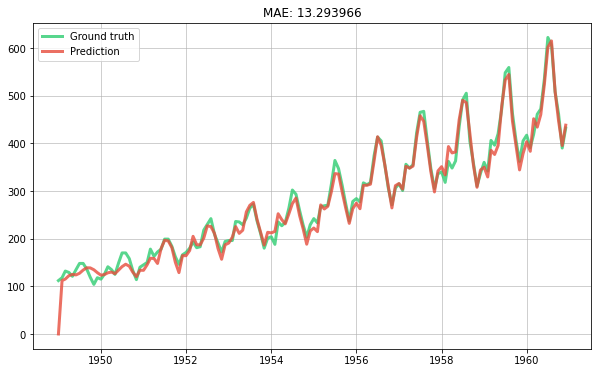

In [9]:
from river import optim

model = compose.Pipeline(
    ('features', compose.TransformerUnion(
        ('ordinal_date', compose.FuncTransformer(get_ordinal_date)),
        ('month', compose.FuncTransformer(get_month)),
    )),
    ('scale', preprocessing.StandardScaler()),
    ('lin_reg', linear_model.LinearRegression(
        intercept_lr=0,
        optimizer=optim.SGD(0.03)
    ))
)

model = preprocessing.TargetStandardScaler(regressor=model)

evaluate_model(model)

This is starting to look good! Naturally in production we would tune the learning rate, ideally in real-time.

Before finishing, we're going to introduce a cool feature extraction trick based on [radial basis function kernels](https://www.wikiwand.com/en/Radial_basis_function_kernel). The one-hot encoding we did on the month is a good idea but if you think about it is a bit rigid. Indeed the value of each feature is going to be 0 or 1, depending on the month of each observation. We're basically saying that the month of September is as distant to the month of August as it is to the month of March. Of course this isn't true, and it would be nice if our features would reflect this. To do so we can simply calculate the distance between the month of each observation and all the months in the calendar. Instead of simply computing the distance linearly, we're going to use a so-called *Gaussian radial basic function kernel*. This is a bit of a mouthful but for us it boils down to a simple formula, which is:

$$d(i, j) = exp(-\frac{(i - j)^2}{2\sigma^2})$$

Intuitively this computes a similarity between two months -- denoted by $i$ and $j$ -- which decreases the further apart they are from each other. The $sigma$ parameter can be seen as a hyperparameter than can be tuned -- in the following snippet we'll simply ignore it. The thing to take away is that this results in smoother predictions than when using a one-hot encoding scheme, which is often a desirable property. You can also see trick in action [in this nice presentation](http://www.youtube.com/watch?v=68ABAU_V8qI&t=4m45s).

<Figure size 720x432 with 1 Axes>

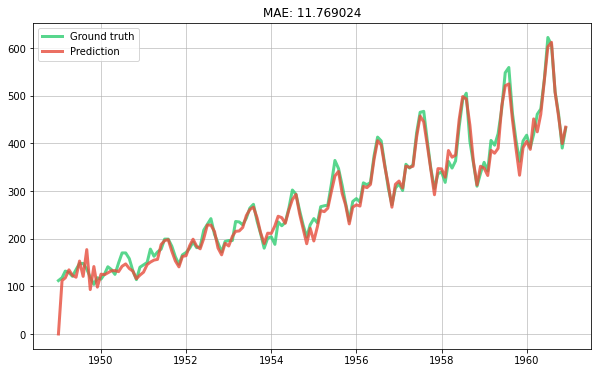

In [10]:
import math

def get_month_distances(x):
    return {
        calendar.month_name[month]: math.exp(-(x['month'].month - month) ** 2)
        for month in range(1, 13)
    }
    

model = compose.Pipeline(
    ('features', compose.TransformerUnion(
        ('ordinal_date', compose.FuncTransformer(get_ordinal_date)),
        ('month_distances', compose.FuncTransformer(get_month_distances)),
    )),
    ('scale', preprocessing.StandardScaler()),
    ('lin_reg', linear_model.LinearRegression(
        intercept_lr=0,
        optimizer=optim.SGD(0.03)
    ))
)

model = preprocessing.TargetStandardScaler(regressor=model)

evaluate_model(model)

We've managed to get a good looking prediction curve with a reasonably simple model. What's more our model has the advantage of being interpretable and easy to debug. There surely are more rocks to squeeze (e.g. tune the hyperparameters, use an ensemble model, etc.) but we'll leave that as an exercice to the reader.

As a finishing touch we'll rewrite our pipeline using the `|` operator, which is called a "pipe".

<Figure size 720x432 with 1 Axes>

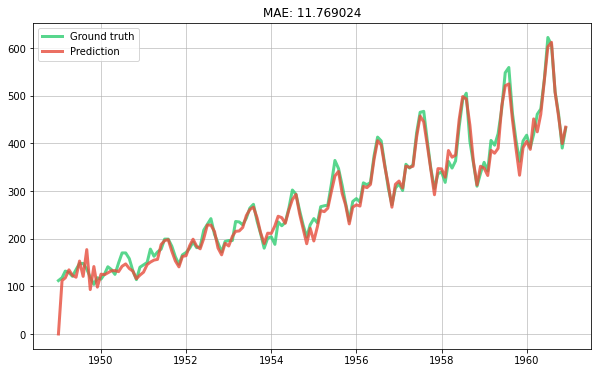

In [11]:
extract_features = compose.TransformerUnion(get_ordinal_date, get_month_distances)

scale = preprocessing.StandardScaler()

learn = linear_model.LinearRegression(
    intercept_lr=0,
    optimizer=optim.SGD(0.03)
)

model = extract_features | scale | learn
model = preprocessing.TargetStandardScaler(regressor=model)

evaluate_model(model)